# Dataset

In [1]:
# Imports
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd

# Mterics initation
metrics = []

# Dataset (WILD v2): https://www.kaggle.com/c/wild-v2
dataset = h5py.File("/mnt/LabData/datasets/indoor_localization/wild-v2/training_data_env1.h5", "r")
# dataset = h5py.File("/mnt/LabData/datasets/indoor_localization/wild-v2/training_data_env2.h5", "r")

# Data initilization
data = {
    "csi": np.array(dataset["channels/real"]).T + 1j * np.array(dataset["channels/imag"]).T,        # (samples, carriers, antennas, APs)
    "rssi": np.array(dataset["rssi"]).T,                                                            # (samples, rssi)
    "labels": np.array(dataset["labels"]).T,                                                        # (samples, true_pos)
    "opt": {
        "ant_sep": np.array(dataset["opt/ANT_SEP"]).flatten()[0],                                   # scalar
        "center_freq": np.array(dataset["opt/CENTER_FREQ"]).flatten()[0],                           # scalar
        "bw": np.array(dataset["opt/BW"]).flatten()[0],                                             # scalar
    },
    "ap_locs": np.mean(np.array(dataset["AP_locs"]), axis=1).T,                                     # (samples, coordinates)
}

# Overview

In [2]:
print("=== Dataset Overview ===")

# Basic Dataset Information
print(f"Total samples                                 : {data['csi'].shape[0]}")
print(f"CSI shape (samples, carriers, antennas, APs)  : {data['csi'].shape}")
print(f"RSSI shape (samples, APs)                     : {data['rssi'].shape}")
print(f"Labels shape (samples, coordinates)           : {data['labels'].shape}")
print(f"Antenna separation                            : {data['opt']['ant_sep']} meters")
print(f"Center frequency                              : {data['opt']['center_freq']} Hz")
print(f"Bandwidth                                     : {data['opt']['bw']} Hz")

=== Dataset Overview ===
Total samples                                 : 17276
CSI shape (samples, carriers, antennas, APs)  : (17276, 234, 4, 6)
RSSI shape (samples, APs)                     : (17276, 6)
Labels shape (samples, coordinates)           : (17276, 2)
Antenna separation                            : 0.0259 meters
Center frequency                              : 5210000000.0 Hz
Bandwidth                                     : 80000000.0 Hz


# Position Analysis


=== Position Profiling ===
Position Data: 
               x          y
0       6.798977 -14.172853
1       6.292617  -6.115303
2       7.069270  -0.138451
3       7.177556  -7.304873
4       6.186538 -13.926446
...          ...        ...
17271   6.847313 -13.204702
17272  -3.041754  -9.939882
17273  -3.640780   1.017346
17274  12.549004 -15.066122
17275   0.702032  -2.076258

[17276 rows x 2 columns]


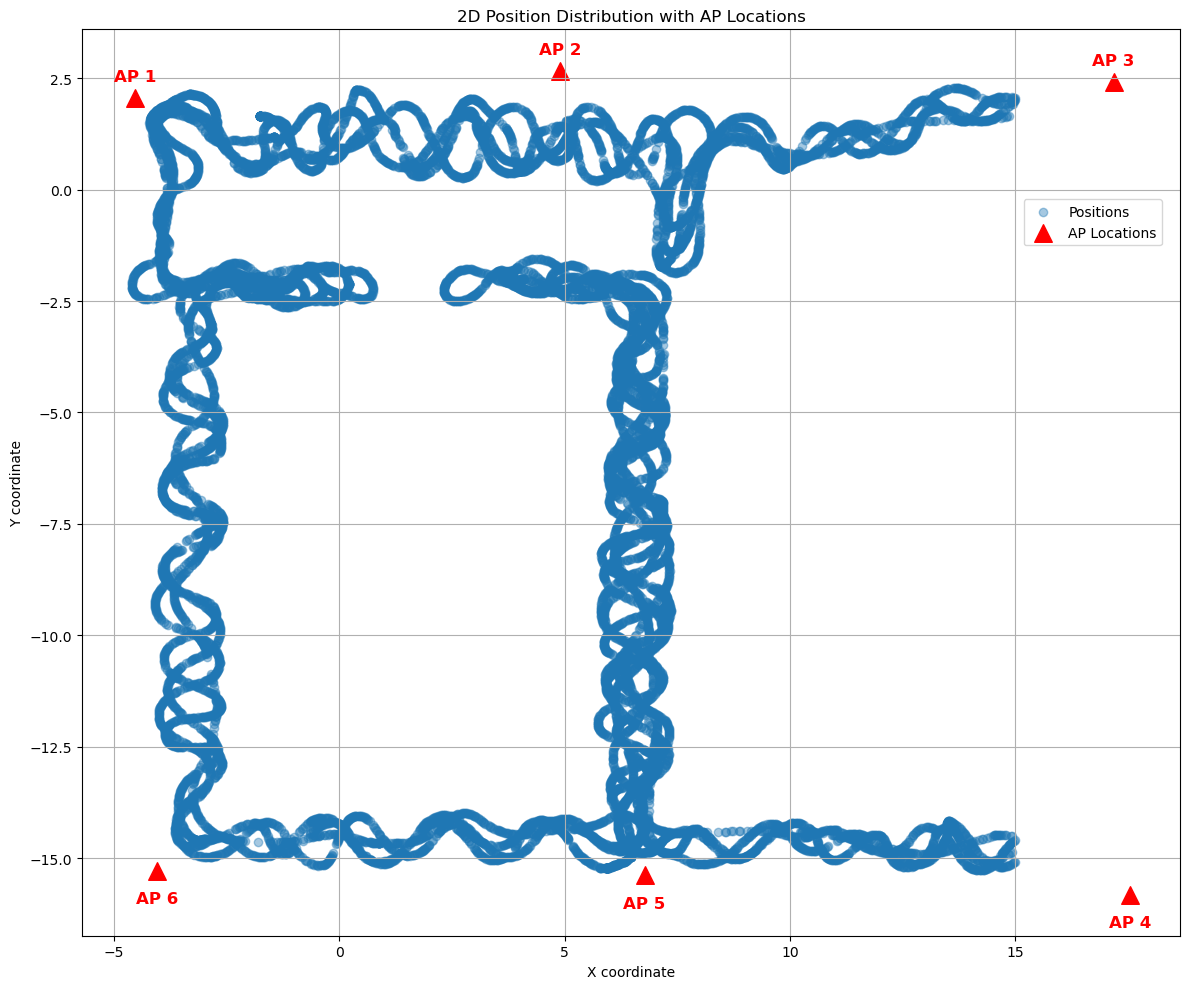

In [3]:
print("\n=== Position Profiling ===")

# Convert to DataFrames
pos_df = pd.DataFrame(data['labels'], columns=['x', 'y'])
ap_df = pd.DataFrame(data['ap_locs'], columns=['x', 'y'])

print(f"Position Data: \n{pos_df}")

# Plot of ENV Map
plt.figure(figsize=(12, 10))
plt.title('2D Position Distribution with AP Locations')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')

# Plotting Positions
plt.scatter(pos_df['x'], pos_df['y'], alpha=0.4, label='Positions')

# Plotting APs
plt.scatter(ap_df['x'], ap_df['y'], s=160, marker='^', color='red', label='AP Locations')
for i, row in ap_df.iterrows():
    if i < 3:  # AP 1 to 3: annotation above
        offset = (0, 10)
        va = 'bottom'
    else:      # AP 4 to 6: annotation below
        offset = (0, -15)
        va = 'top'

    plt.annotate(f'AP {i+1}',
                 (row['x'], row['y']),
                 textcoords="offset points",
                 xytext=offset,
                 ha='center',
                 va=va,
                 color='red',
                 fontsize=12,
                 fontweight='bold')

plt.legend(loc='upper right', bbox_to_anchor=(0.99, 0.82))
plt.tight_layout()
plt.grid(True)
plt.show()

           x          y
0  -4.525536   2.057204
1   4.905565   2.670063
2  17.176555   2.416904
3  17.543673 -15.814430
4   6.774813 -15.379450
5  -4.038577 -15.279211


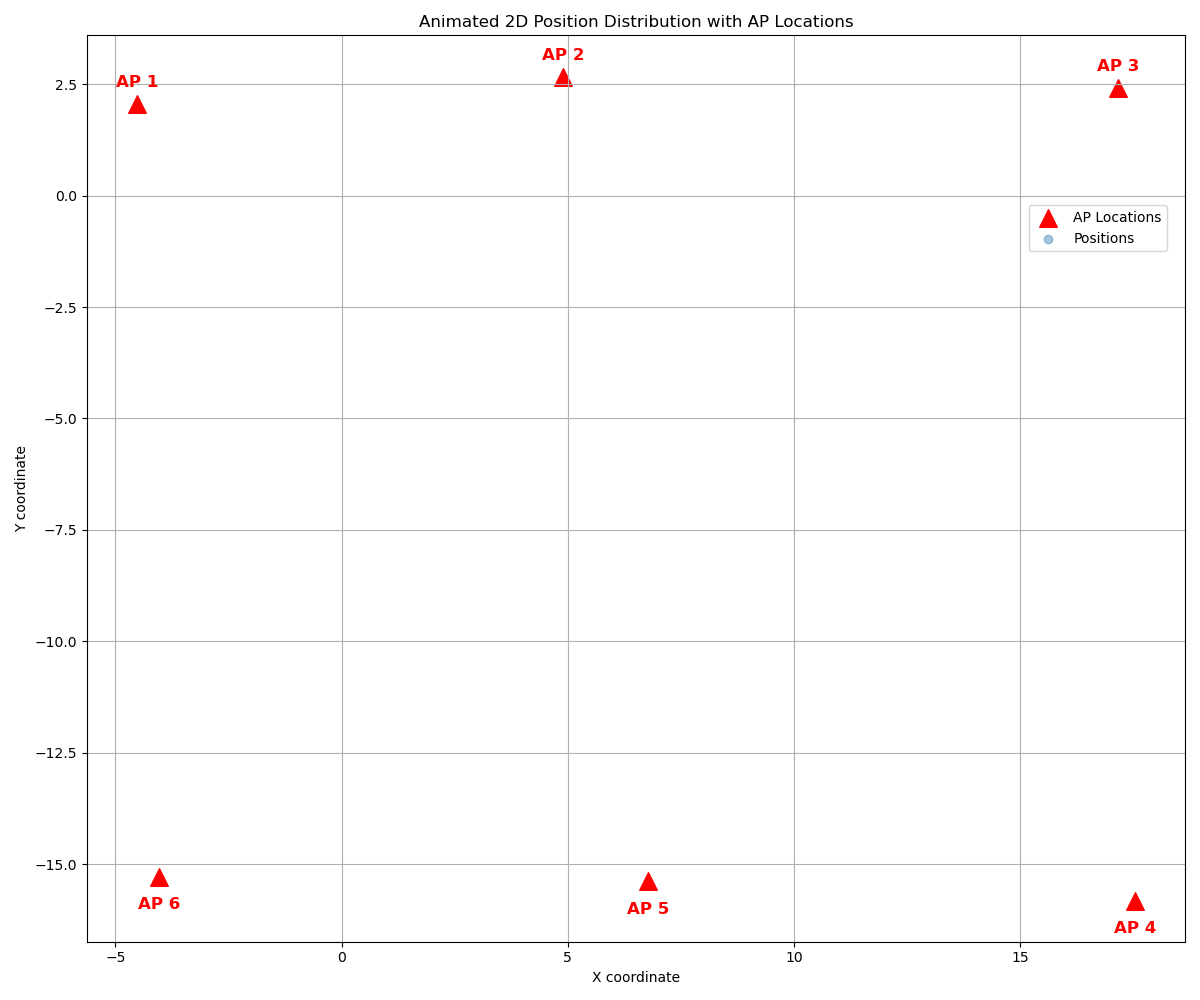

In [4]:
%matplotlib widget
# path animation
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create DataFrames (assuming `data` is predefined)
pos_df = pd.DataFrame(data['labels'], columns=['x', 'y'])
ap_df = pd.DataFrame(data['ap_locs'], columns=['x', 'y'])
print(ap_df)

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title('Animated 2D Position Distribution with AP Locations')
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')

# Scatter for APs
ax.scatter(ap_df['x'], ap_df['y'], s=160, marker='^', color='red', label='AP Locations')
for i, row in ap_df.iterrows():
    if i < 3:
        offset = (0, 10)
        va = 'bottom'
    else:
        offset = (0, -15)
        va = 'top'

    ax.annotate(f'AP {i+1}',
                (row['x'], row['y']),
                textcoords="offset points",
                xytext=offset,
                ha='center',
                va=va,
                color='red',
                fontsize=12,
                fontweight='bold')

scat = ax.scatter([], [], alpha=0.4, label='Positions')
ax.legend(loc='upper right', bbox_to_anchor=(0.99, 0.82))
ax.grid(True)

# Initialization function
def init():
    scat.set_offsets(np.empty((0, 2)))  # Proper 2D shape
    return scat,

# Update function for animation
def update(frame):
    current = pos_df.iloc[:frame+1]
    scat.set_offsets(current[['x', 'y']].values)
    return scat,

# Create the animation
ani = animation.FuncAnimation(
    fig, update, frames=len(pos_df), init_func=init,
    blit=True, interval=50, repeat=False
)

plt.tight_layout()
plt.show()


In [5]:
import pandas as pd
import plotly.graph_objects as go

# DataFrames
pos_df = pd.DataFrame(data['labels'], columns=['x', 'y'])
ap_df = pd.DataFrame(data['ap_locs'], columns=['x', 'y'])

# Base scatter for APs (static)
ap_trace = go.Scatter(
    x=ap_df['x'],
    y=ap_df['y'],
    mode='markers+text',
    marker=dict(size=14, symbol='triangle-up', color='red'),
    text=[f'AP {i+1}' for i in range(len(ap_df))],
    textposition=['top center']*3 + ['bottom center']*3,
    name='AP Locations'
)

# Initial position trace (empty)
position_trace = go.Scatter(
    x=[],
    y=[],
    mode='lines+markers',
    line=dict(color='blue'),
    marker=dict(size=6),
    name='Position Path'
)

# Build animation frames
frames = [
    go.Frame(
        data=[go.Scatter(x=pos_df['x'][:i], y=pos_df['y'][:i])],
        name=str(i)
    )
    for i in range(1, len(pos_df) + 1)
]

# Define the figure
fig = go.Figure(
    data=[ap_trace, position_trace],
    layout=go.Layout(
        title='Animated Position Path with AP Locations',
        xaxis=dict(title='X Coordinate', range=[pos_df['x'].min() - 5, pos_df['x'].max() + 5]),
        yaxis=dict(title='Y Coordinate', range=[pos_df['y'].min() - 5, pos_df['y'].max() + 5]),
        updatemenus=[
            dict(
                type="buttons",
                showactive=False,
                buttons=[
                    dict(label="▶️ Play", method="animate",
                         args=[None, {"frame": {"duration": 50, "redraw": True},
                                      "fromcurrent": True}]),
                    dict(label="⏸ Pause", method="animate",
                         args=[[None], {"frame": {"duration": 0, "redraw": False},
                                        "mode": "immediate",
                                        "transition": {"duration": 0}}])
                ],
                x=1.05,
                y=1.15
            )
        ],
        sliders=[dict(
            steps=[
                dict(method='animate',
                     args=[[str(k)], dict(mode='immediate',
                                          frame=dict(duration=50, redraw=True),
                                          transition=dict(duration=0))],
                     label=str(k))
                for k in range(1, len(pos_df)+1)
            ],
            transition=dict(duration=0),
            x=0.1,
            y=0,
            currentvalue=dict(prefix='Frame: '),
            len=0.9
        )]
    ),
    frames=frames  # ✅ Here is where frames belong!
)

fig.show()


KeyboardInterrupt: 

# RSSI Analysis

In [ ]:
# RSSI Analysis

import indolocate.utils as utils
import pandas as pd
import numpy as np

def analyze_rssi(data):
    # Check for NaN and Inf
    has_nan = np.isnan(data).any()
    has_inf = np.isinf(data).any()

    # Filter out NaN and Inf for max/min calculations
    finite_data = data[np.isfinite(data)]  # Removes both NaN and Inf
    max_val = np.max(finite_data) if finite_data.size > 0 else np.nan
    min_val = np.min(finite_data) if finite_data.size > 0 else np.nan

    df = pd.DataFrame(data)
    # Print summary (avoid printing large DataFrames)
    print(f"Shape: {np.shape(data)}")
    print(f"Contains NaNs: {has_nan}")
    print(f"Contains infs: {has_inf}")
    print(f"Max value (finite only): {max_val}")
    print(f"Min value (finite only): {min_val}")
    # print(f"Basic stats: {df.describe()} \n")
    print(f"Data: \n{df}")


    # Visualization
    plt.figure(figsize=(15, 6))
    for ap in range(df.shape[1]):
        sns.kdeplot(df.iloc[:, ap], label=f'AP {ap+1}')
    plt.title('RSSI Distribution per Access Point')
    plt.xlabel('RSSI (dBm)')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    # Correlation between APs
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('RSSI Correlation Between APs')
    plt.show()


print("\n=== RSSI Original ===")
analyze_rssi(data['rssi'])

print("\n=== RSSI Processed ===")
X_test1, Y_test1 = utils.preprocess_rssi(data['rssi'], data['labels'], smooth_window=1)
analyze_rssi(X_test1)

# CSI Analysis

In [ ]:
# CSI Data analysis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def analyze_csi(csi):
    """
    Assumes CSI is a complex-valued numpy array with shape:
    (samples, subcarriers, antennas, APs)
    """
    print(f"CSI shape: {csi.shape}")
    samples, subcarriers, antennas, aps = csi.shape

    # ----- Magnitude Analysis -----
    magnitude = np.abs(csi)
    avg_magnitude = np.mean(magnitude, axis=(1, 2))  # shape: (samples, APs)
    
    has_nan = np.isnan(avg_magnitude).any()
    has_inf = np.isinf(avg_magnitude).any()
    finite_mag = avg_magnitude[np.isfinite(avg_magnitude)]
    
    print("\n--- Magnitude Stats ---")
    print(f"Shape: {avg_magnitude.shape}")
    print(f"Contains NaNs: {has_nan}")
    print(f"Contains Infs: {has_inf}")
    print(f"Max value: {np.max(finite_mag) if finite_mag.size > 0 else np.nan}")
    print(f"Min value: {np.min(finite_mag) if finite_mag.size > 0 else np.nan}")

    mag_df = pd.DataFrame(avg_magnitude)
    print(f"Data:\n{mag_df}")

    # KDE plot for Magnitude
    plt.figure(figsize=(15, 6))
    for ap in range(mag_df.shape[1]):
        sns.kdeplot(mag_df.iloc[:, ap], label=f'AP {ap+1}')
    plt.title('CSI Magnitude Distribution per AP')
    plt.xlabel('Mean Magnitude')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    # Correlation for Magnitude
    plt.figure(figsize=(10, 8))
    sns.heatmap(mag_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('CSI Magnitude Correlation Between APs')
    plt.show()

    # ----- Phase Analysis -----
    phase = np.angle(csi)  # shape: (samples, subcarriers, antennas, APs)
    avg_phase = np.mean(phase, axis=(1, 2))  # shape: (samples, APs)

    has_nan_phase = np.isnan(avg_phase).any()
    has_inf_phase = np.isinf(avg_phase).any()
    finite_phase = avg_phase[np.isfinite(avg_phase)]

    print("\n--- Phase Stats ---")
    print(f"Shape: {avg_phase.shape}")
    print(f"Contains NaNs: {has_nan_phase}")
    print(f"Contains Infs: {has_inf_phase}")
    print(f"Max value: {np.max(finite_phase) if finite_phase.size > 0 else np.nan}")
    print(f"Min value: {np.min(finite_phase) if finite_phase.size > 0 else np.nan}")

    phase_df = pd.DataFrame(avg_phase)
    print(f"Data:\n{phase_df}")

    # KDE plot for Phase
    plt.figure(figsize=(15, 6))
    for ap in range(phase_df.shape[1]):
        sns.kdeplot(phase_df.iloc[:, ap], label=f'AP {ap+1}')
    plt.title('CSI Phase Distribution per AP')
    plt.xlabel('Mean Phase (radians)')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    # Correlation for Phase
    plt.figure(figsize=(10, 8))
    sns.heatmap(phase_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('CSI Phase Correlation Between APs')
    plt.show()

print("Original:")
analyze_csi(data['csi'])

# X_test1, Y_test1 = utils.preprocess_csi(data['rssi'], data['labels'])
# print("Processed:")
# analyze_csi(X_test1)